Michael Muschitiello // Implications of Beta on Return Forecasts

##### The goal of this notebook is to analyze the implications of concentration on the calculation of beta, as well as determine the effect of this concentration&calculation on estimating/forecasting returns. Road map is as follows: 

- Test daily and weekly log returns for serial correlation. Because we intend to use WLS regression, as well as GBM simulation, we prefer to have data with little to no serial correlation

- Download and clean weekly data for a basket of stocks including
    - Magnificent 7 + Energy Sector stocks + Real Estate sector stocks
        - The throught process behind stock selection was derived from analysis of the correlation matrix of the SPDR sector ETFs over a 10 year period to identify which sectors have the lowest correlation with the tech industry, which will provide meaningful analysis into visualizing the implications of the current concentration of the SP500 on estimating/forecasting stock returns

- Compute log returns for the basket of stock in preparation for Geometric Brownian Motion stock modeling

- Compute beta for each stock using Weighted Least Squares Regression applying an exponential time decay to the time series data to give more relevance to more recent observations. 
    - Computing betas of each stock relative to the SPX, and RSP respectively
        - We find that tech stocks have higher betas, particularly when the SPX is used as a market benchmark 

- Calibrate the first 2 moments of the SPX and RSP using 10 years of weekly log returns.
    - Simulate the 2025 price path of SPX and RSP to average terminal values to estimate an Expected Return for the Market Index in preparation for a simple CAPM calculation of expected returns of a given stock
        - Averaging the 2 market return expectations to have a single Expected Return of the Market to isolate the effect of beta in the CAPM formula

- Fetch 1y Constant Maturity Rate to represent risk-free rate in the CAPM formula
    - Compute 2 expected returns for each stock--one using SPX based beta, one using RSP based beta

- Calculating annualized volatility of each stock in preparation for GBM simulation 

- Simulating 2025 price paths for each stock using different mu terms based off E[R] with respect to spx and rsp
    - Computing and plotting cumulative returns for both sets of simulation
    - Computing and plotting daily returns for each stock in a histogram

In [28]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.optimize import fsolve
import datetime as dt
import math 
from time import time
import scipy.stats as stats

from fredapi import Fred
API_KEY = "9da7edac51a3a1adab2418a20abb4d0d"
fred = Fred(api_key=API_KEY)

**Testing daily and weekly data for serial correlation**

In [2]:
tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'META', 'AMZN', 'TSLA', 'XOM', 'CVX', 'COP', 'ET', 'PLD', 'AMT', 'WELL', 'SPG']  
start_date = "2020-01-01"
end_date = "2025-01-01"

daily_data = yf.download(tickers, start=start_date, end=end_date)['Close']
weekly_data = daily_data.resample('W').last()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  15 of 15 completed


In [3]:
daily_log_returns = np.log(daily_data / daily_data.shift(1))
weekly_log_returns = np.log(weekly_data / weekly_data.shift(1))

Average Ljung-Box p-value for Daily Log Returns: 0.0447
Average Ljung-Box p-value for Weekly Log Returns: 0.3473


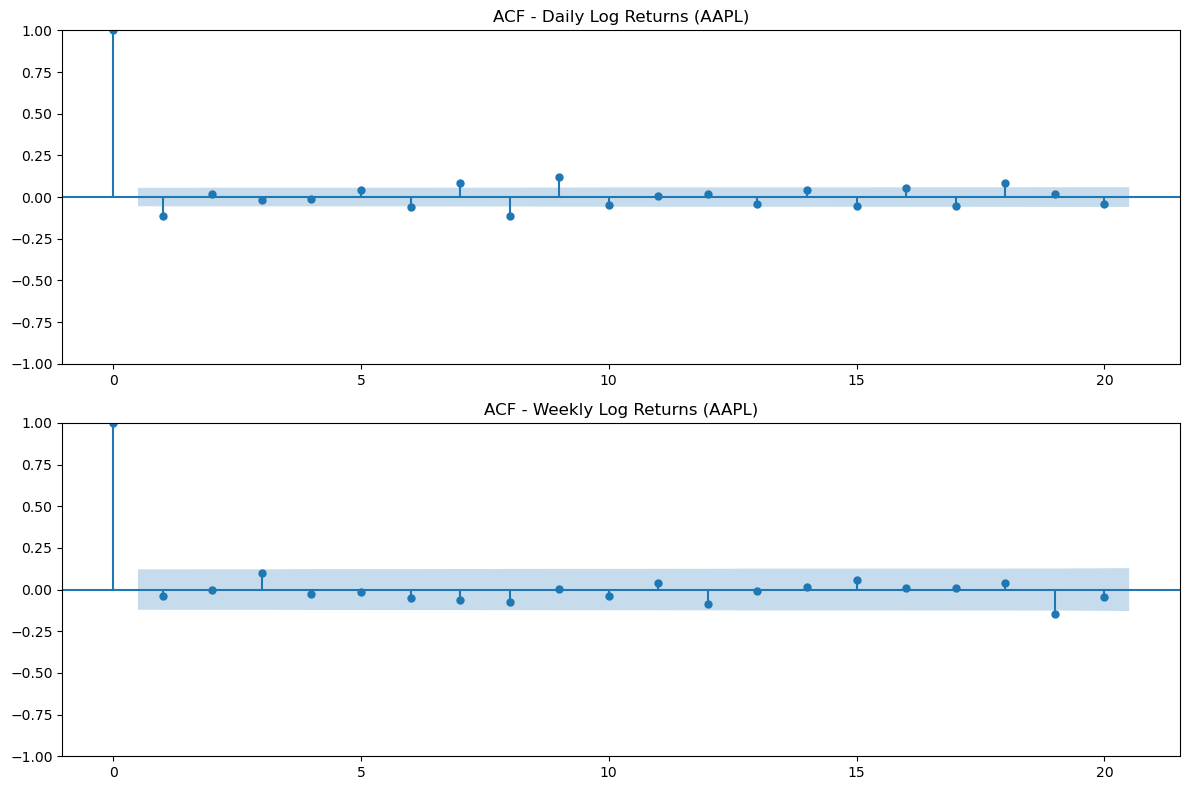

In [4]:
# testing both for serial correlation 
# Ljung-Box test for serial correlation in log returns
def average_ljungbox_pvalue(log_returns, lags=15):
    """
    For each column (stock) in the log_returns DataFrame, perform the Ljung-Box test
    using the specified number of lags and return the average p-value.
    
    Args:
        log_returns (pd.DataFrame): DataFrame of log returns (rows=time, columns=tickers)
        lags (int): The number of lags to test.
    
    Returns:
        float: The average p-value across stocks.
    """
    p_values = []
    for col in log_returns.columns:
        series = log_returns[col].dropna()
        # Use a single lag test (e.g. lag=10), result is a DataFrame with the p-value for each lag
        lb_test = acorr_ljungbox(series, lags=[lags], return_df=True)
        p_values.append(lb_test['lb_pvalue'].iloc[-1])
    return np.mean(p_values)

# testing serial correlation for daily and weekly log returns
avg_p_daily = average_ljungbox_pvalue(daily_log_returns, lags=10)
avg_p_weekly = average_ljungbox_pvalue(weekly_log_returns, lags=10)

print("Average Ljung-Box p-value for Daily Log Returns: {:.4f}".format(avg_p_daily))
print("Average Ljung-Box p-value for Weekly Log Returns: {:.4f}".format(avg_p_weekly))

# plotting ACFs for daily and weekly log returns for a single stock
# NOTE: just plots for 1 stock, not all stocks
example_ticker = tickers[0] 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# plot ACF for daily log returns
sm.graphics.tsa.plot_acf(daily_log_returns[example_ticker].dropna(), lags=20, ax=ax1)
ax1.set_title(f"ACF - Daily Log Returns ({example_ticker})")

# plot ACF for weekly log returns
sm.graphics.tsa.plot_acf(weekly_log_returns[example_ticker].dropna(), lags=20, ax=ax2)
ax2.set_title(f"ACF - Weekly Log Returns ({example_ticker})")

plt.tight_layout()
plt.show()

In [5]:

def download_clean_log_returns(ticker_list, start_date, end_date, interval='1wk'):
    """
    Downloads historical price data for the given tickers, cleans the data by forward-
    and backward-filling missing values, and computes daily log returns.
    
    Args:
        ticker_list (list): List of ticker symbols.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        interval (str): Data interval (e.g., '1wk').
        
    Returns:
        prices (pd.DataFrame): Cleaned closing prices.
        log_returns (pd.DataFrame): Daily log returns.
    """
    # download hist data
    data = yf.download(ticker_list, start=start_date, end=end_date, interval=interval)
    
    # use the close price
    if 'Close' in data.columns:
        prices = data['Close']
    else:
        prices = data
     
    # clean
    prices = prices.ffill().bfill()
    
    # compute log rets
    log_returns = np.log(prices / prices.shift(1)).dropna()
    
    return prices, log_returns


# focusing on tech, energy, real estate
tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'META', 'AMZN', 'TSLA', 'XOM', 'CVX', 'COP', 'ET', 'PLD', 'AMT', 'WELL', 'SPG']  
start_date = "2020-01-01"
end_date = "2025-01-01"

prices, log_returns = download_clean_log_returns(tickers, start_date, end_date)
print("Cleaned Prices:")
print(prices.head())
print("\nDaily Log Returns:")
print(log_returns.head())

[*********************100%***********************]  15 of 15 completed

Cleaned Prices:
Ticker           AAPL         AMT        AMZN        COP        CVX        ET  \
Date                                                                            
2020-01-01  72.241539  196.205933   95.343002  54.784943  94.281921  8.483157   
2020-01-08  75.701225  205.214523   93.472000  53.680672  92.096329  8.439591   
2020-01-15  76.643005  207.653061   94.599998  52.765942  89.728592  8.140842   
2020-01-22  76.914154  208.047821   92.662498  50.417316  87.994362  7.960348   
2020-01-29  77.195023  208.284622  102.483498  46.552372  84.612999  8.016367   

Ticker           GOOG        META        MSFT      NVDA        PLD  \
Date                                                                 
2020-01-01  69.417580  212.249207  150.421326  5.973209  77.607155   
2020-01-08  71.287849  218.226379  154.764648  6.156191  79.501930   
2020-01-15  73.954277  220.597351  158.936172  6.172623  83.835373   
2020-01-22  72.367973  216.961227  157.943420  6.173369  83.826614

download data for rsp, spx

In [6]:
mkt_prices, mkt_logrets = download_clean_log_returns(['SPY', 'RSP'], start_date, end_date)
mkt_prices , mkt_logrets

[*********************100%***********************]  2 of 2 completed


(Ticker             RSP         SPY
 Date                              
 2020-01-01  105.788025  299.210846
 2020-01-08  107.125946  303.586975
 2020-01-15  108.051506  307.156219
 2020-01-22  106.264534  303.067688
 2020-01-29  106.282883  305.079620
 ...                ...         ...
 2024-11-27  185.666107  601.884216
 2024-12-04  182.656693  600.777954
 2024-12-11  179.497818  602.262939
 2024-12-18  176.986664  599.283020
 2024-12-25  175.229996  586.080017
 
 [261 rows x 2 columns],
 Ticker           RSP       SPY
 Date                          
 2020-01-08  0.012568  0.014520
 2020-01-15  0.008603  0.011688
 2020-01-22 -0.016676 -0.013400
 2020-01-29  0.000173  0.006617
 2020-02-05  0.016419  0.018666
 ...              ...       ...
 2024-11-27 -0.004872  0.005413
 2024-12-04 -0.016342 -0.001840
 2024-12-11 -0.017445  0.002469
 2024-12-18 -0.014089 -0.004960
 2024-12-25 -0.009975 -0.022278
 
 [260 rows x 2 columns])

In [7]:

def calculate_wls_betas(stock_logrets, mkt_logrets, lmbda=0.9966571):
    """
    for each stock column in stock_logrets, run a WLS regression against mkt_logrets 
    using exponential decay with parameter lmbda. The regression is:
    
       y = alpha + beta * X
      
    where y is the stock's log returns and X is mkt_logrets.
    
    args:
        stock_logrets (pd.DataFrame): Each column represents a stock's log returns.
        mkt_logrets (pd.Series): A Series of mkt log returns (X variable).
        lmbda (float): The exponential decay factor.
        
    Returns:
        pd.DataFrame: A DataFrame with index as ticker symbols and a column "beta" of computed beta values.
    """
    betas = {}
    T = len(mkt_logrets)
    # generate exponential decay weights such that the oldest observation gets weight = lmbda^(T-1-i)(using 50% weight for first observation)
    weights = np.array([lmbda ** (T - 1 - i) for i in range(T)], dtype=np.float64)
    
    # prepare independent variable by adding constant to mkt_logrets
    X = sm.add_constant(mkt_logrets)
    
    # loop over each stock ticker in the DataFrame columns
    for ticker in stock_logrets.columns:
        y = stock_logrets[ticker]
        # Ensure y is aligned with mkt_logrets (same index)
        common_index = X.index.intersection(y.index)
        X_common = X.loc[common_index]
        y_common = y.loc[common_index]
        # adjust weights to the common index length if necessary
        weights_common = weights[-len(y_common):]
        model = sm.WLS(y_common, X_common, weights=weights_common)
        res = model.fit()
        betas[ticker] = res.params[1]  # beta coefficient
        
    # convert dictionary to DataFrame
    beta_df = pd.DataFrame.from_dict(betas, orient='index', columns=['beta'])
    beta_df.index.name = 'Ticker'
    return beta_df

In [8]:
spx_betas = calculate_wls_betas(log_returns, mkt_logrets['SPY'])
rsp_betas = calculate_wls_betas(log_returns, mkt_logrets['RSP'])
betas_df = pd.concat([spx_betas, rsp_betas], axis=1)
betas_df.columns = ['beta_spx', 'beta_rsp']
betas_df = betas_df.reindex(tickers)
betas_df['Bspx - Brsp'] = betas_df['beta_spx'] - betas_df['beta_rsp']
betas_df

C:\Users\musch\AppData\Local\Temp\ipykernel_65140\3763582726.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[ticker] = res.params[1]  # beta coefficient
C:\Users\musch\AppData\Local\Temp\ipykernel_65140\3763582726.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[ticker] = res.params[1]  # beta coefficient


,beta_spx,beta_rsp,Bspx - Brsp
Ticker,,,
AAPL,1.177850,0.775970,0.401880
MSFT,1.111290,0.705232,0.406058
NVDA,1.971545,1.222569,0.748976
GOOG,1.157392,0.774800,0.382593
META,1.455082,0.952009,0.503072
AMZN,1.365389,0.912181,0.453208
TSLA,2.106458,1.468801,0.637658
XOM,0.653554,0.883264,-0.229710
CVX,0.762861,0.943611,-0.180750


# Simulating market paths of SPX and RSP using GBM with calibrated parameters

$$S_{t+\Delta t} = S_t \exp \left[ \left(\mu - \frac{\sigma^2}{2} \right) \Delta t + \sigma \varepsilon \sqrt{\Delta t} \right]$$


[*********************100%***********************]  1 of 1 completed
C:\Users\musch\AppData\Local\Temp\ipykernel_65140\145648429.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(sigma)
C:\Users\musch\AppData\Local\Temp\ipykernel_65140\145648429.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(mu)
C:\Users\musch\AppData\Local\Temp\ipykernel_65140\145648429.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(historical_data.iloc[-1])


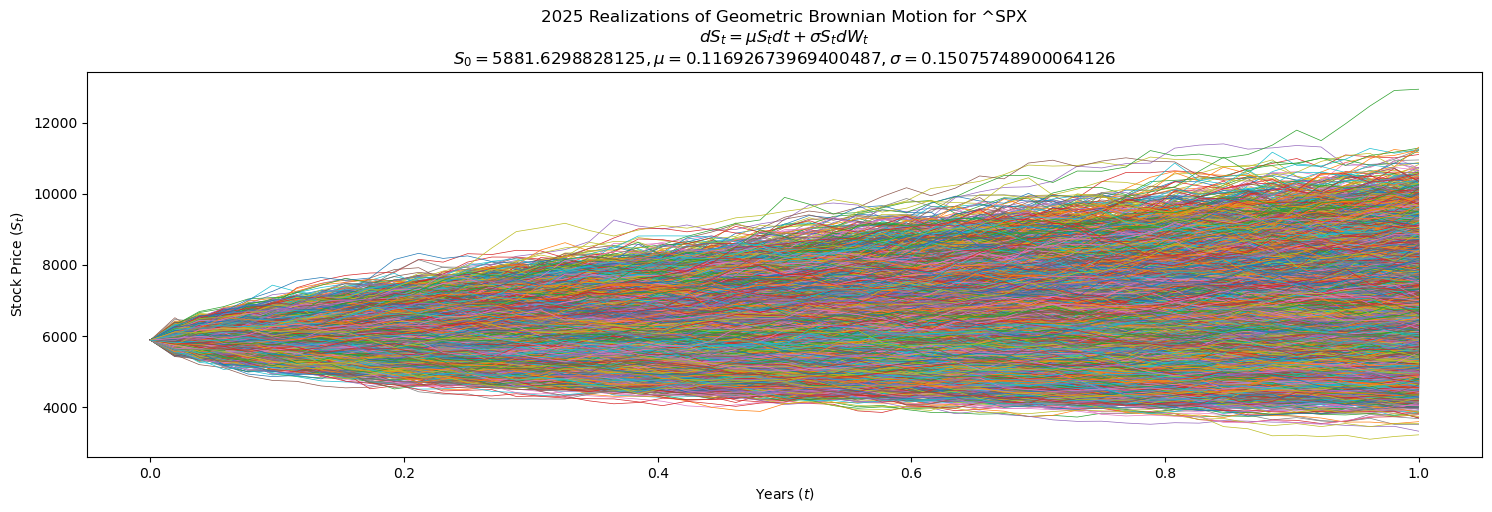

[*********************100%***********************]  1 of 1 completed

Expected terminal value (^SPX): 6607.269207791363
Expected Return (^SPX): 12.34 %



C:\Users\musch\AppData\Local\Temp\ipykernel_65140\145648429.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(sigma)
C:\Users\musch\AppData\Local\Temp\ipykernel_65140\145648429.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(mu)
C:\Users\musch\AppData\Local\Temp\ipykernel_65140\145648429.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(historical_data.iloc[-1])


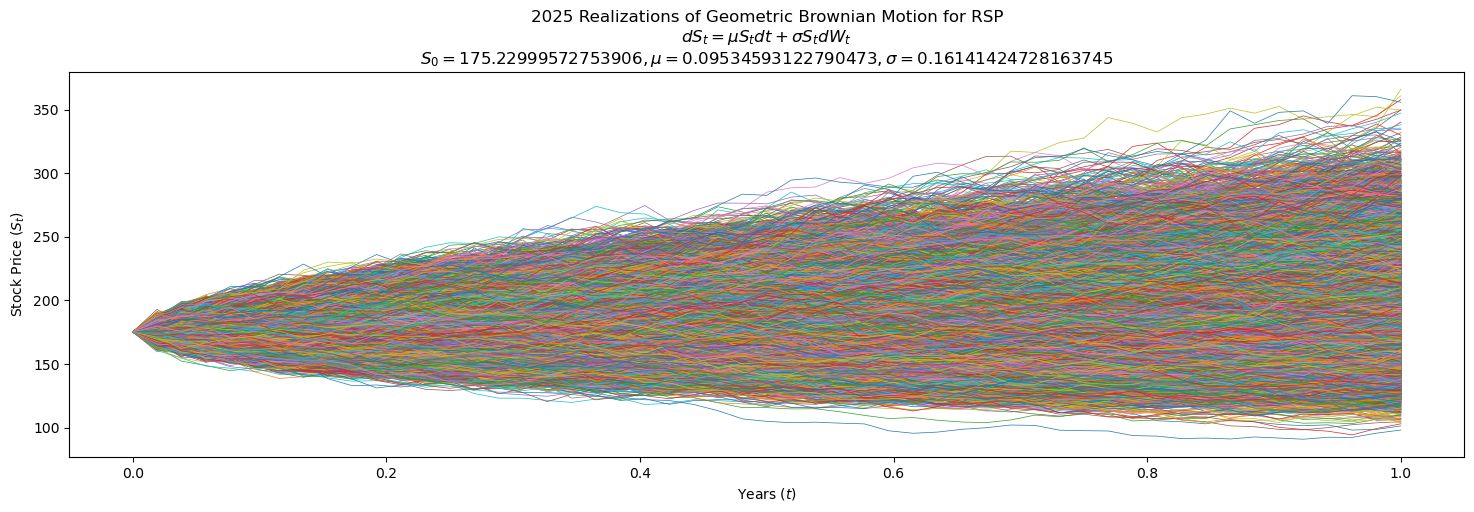

Expected terminal value (RSP): 192.99481135339695
Expected Return (RSP): 10.14 %

Saved Expected Return for SPX: 12.34 %
Saved Expected Return for RSP: 10.14 %


In [9]:
def simulate_market(ticker, start_date, end_date, dt=1/52, n=52, m=50000):
    """
    Simulates GBM price paths for a market index or ETF based on historical data,
    and returns the expected terminal price and return along with other parameters.
    
    Args:
        ticker (str): Ticker symbol (e.g. '^SPX' or 'RSP').
        start_date (str): Start date for historical data (e.g. '2014-01-01').
        end_date (str): End date for historical data (e.g. '2024-12-31').
        dt (float): Time increment in years (default is 1/52 for weekly steps).
        n (int): Number of time steps (default 52 for one year).
        m (int): Number of simulation paths (default 50,000).
    
    Returns:
        St (np.ndarray): Simulated price paths (shape: (n+1, m)).
        mu (float): Calibrated annual drift.
        sigma (float): Calibrated annual volatility.
        historical_data (pd.Series): Historical closing prices.
        expected_return (float): Expected return computed from the simulation.
    """
    # download and clean
    historical_data = yf.download(ticker, start=start_date, end=end_date, 
                                  interval='1wk', auto_adjust=False)['Close']
    historical_data = historical_data.ffill().bfill()
    
    # compute weekly logrets
    hist_logrets = np.log(historical_data / historical_data.shift(1)).dropna()
    
    # calibrate annual drift and vol
    sigma = hist_logrets.std() / np.sqrt(dt)  # annualized volatility
    mu = hist_logrets.mean() / dt + (sigma**2)/2  # annualized drift (adjusted)
    
    # ensure data structure
    sigma = float(sigma)
    mu = float(mu)
    
    # nitial price from the last available historical price
    S0 = float(historical_data.iloc[-1])
    
    # Simulate GBM paths
    # generate normal random shocks with shape (n, m)
    shocks = np.random.normal(0, np.sqrt(dt), size=(n, m))
    
    # compute relative price changes using the GBM formula
    St = np.exp((mu - 0.5 * sigma**2) * dt + sigma * shocks)
    
    # prepend an initial row of ones and compute the cumulative product for each simulation path
    St = np.vstack([np.ones(m), St])
    St = S0 * St.cumprod(axis=0)
    
    # create a time axis for plotting
    time_axis = np.linspace(0, n * dt, n+1)
    tt = np.full((m, n+1), time_axis).T  # shape (n+1, m)
    
    # plot paths
    plt.figure(figsize=(18, 5))
    plt.plot(tt, St, linewidth=0.5)
    plt.xlabel("Years $(t)$")
    plt.ylabel("Stock Price $(S_t)$")
    plt.title(
        "2025 Realizations of Geometric Brownian Motion for {ticker}\n"
        "$dS_t = \\mu S_t dt + \\sigma S_t dW_t$ \n"
        "$S_0 = {S0}, \\mu = {mu}, \\sigma = {sigma}$".format(
            ticker=ticker, S0=S0, mu=mu, sigma=sigma
        )
    )
    plt.show()
    
    # calculate expected terminal value and expected return
    E_St = np.mean(St[-1])
    expected_return = (E_St - S0) / S0
    
    print(f"Expected terminal value ({ticker}): {E_St}")
    print(f"Expected Return ({ticker}): {expected_return*100:.2f} %")
    
    return St, mu, sigma, historical_data, expected_return


spx_sim, spx_mu, spx_sigma, spx_hist, spx_expected_return = simulate_market(
    ticker="^SPX",
    start_date="2014-01-01",
    end_date="2024-12-31",
    dt=1/52,
    n=52,
    m=50000
)

rsp_sim, rsp_mu, rsp_sigma, rsp_hist, rsp_expected_return = simulate_market(
    ticker="RSP",
    start_date="2014-01-01",
    end_date="2024-12-31",
    dt=1/52,
    n=52,
    m=50000
)

expected_return_spx = spx_expected_return
expected_return_rsp = rsp_expected_return

print(f"\nSaved Expected Return for SPX: {expected_return_spx*100:.2f} %")
print(f"Saved Expected Return for RSP: {expected_return_rsp*100:.2f} %")

In [10]:
# averaging expected return to get a single value for CAPM implementation
E_r_mkt = (expected_return_spx + expected_return_rsp) / 2
rsp_expected_return, spx_expected_return, E_r_mkt

(0.10137999234720053, 0.12337385035045328, 0.1123769213488269)

### Fetching latest rf-rate for 1/1/2025

In [11]:
# fetching rf rate: latest rf rate in 2024

observation_start = '2024-12-26'
observation_end   = '2025-01-05'

# Fetch the 1-year CMT (GS1) series from FRED
data = fred.get_series(
    series_id='GS1',
    observation_start=observation_start,
    observation_end=observation_end
)

# Drop any NaNs
data.dropna(inplace=True)

if data.empty:
    print("No data found in the specified date range.")
else:
    # The index is a DatetimeIndex of business days for which FRED has data
    first_2024_date = data.index[-1]           
    first_2024_rate = data.iloc[-1]            
    print(f"Last available 2024 date: {first_2024_date.date()}")
    print(f"1-year CMT on that date: {first_2024_rate:.2f}%")

Last available 2024 date: 2025-01-01
1-year CMT on that date: 4.18%


### Computing expected returns for each stock using beta from ^SPX, and RSP using: 

$$\mu = r_f + \beta_m (r_m - r_f)$$

Where: 

- $r_f$ is the 1 year Treasury Constant Maturity Rate
- $\beta_m$ is the beta of the stock 
- $r_m$ is the expected return of the market

In [12]:
CMT_1y = first_2024_rate / 100 #NOTE

betas_df['Expected Return(Bspx)'] = betas_df.apply(
    lambda row: CMT_1y + row['beta_spx'] * (E_r_mkt - CMT_1y),
    axis=1)

betas_df['Expected Return(Brsp)'] = betas_df.apply(
    lambda row: CMT_1y + row['beta_rsp'] * (E_r_mkt - CMT_1y),
    axis=1
)

betas_df 

,beta_spx,beta_rsp,Bspx - Brsp,Expected Return(Bspx),Expected Return(Brsp)
Ticker,,,,,
AAPL,1.177850,0.775970,0.401880,0.124929,0.096566
MSFT,1.111290,0.705232,0.406058,0.120231,0.091573
NVDA,1.971545,1.222569,0.748976,0.180946,0.128085
GOOG,1.157392,0.774800,0.382593,0.123485,0.096483
META,1.455082,0.952009,0.503072,0.144495,0.108990
AMZN,1.365389,0.912181,0.453208,0.138165,0.106179
TSLA,2.106458,1.468801,0.637658,0.190467,0.145463
XOM,0.653554,0.883264,-0.229710,0.087926,0.104138
CVX,0.762861,0.943611,-0.180750,0.095640,0.108397


In [13]:
# convert expected return columns to percentages 
betas_df['Expected Return(Brsp)'] = betas_df['Expected Return(Brsp)'] * 100
betas_df['Expected Return(Bspx)'] = betas_df['Expected Return(Bspx)'] * 100
betas_df 

,beta_spx,beta_rsp,Bspx - Brsp,Expected Return(Bspx),Expected Return(Brsp)
Ticker,,,,,
AAPL,1.177850,0.775970,0.401880,12.492900,9.656556
MSFT,1.111290,0.705232,0.406058,12.023145,9.157310
NVDA,1.971545,1.222569,0.748976,18.094558,12.808513
GOOG,1.157392,0.774800,0.382593,12.348519,9.648298
META,1.455082,0.952009,0.503072,14.449518,10.898988
AMZN,1.365389,0.912181,0.453208,13.816496,10.617895
TSLA,2.106458,1.468801,0.637658,19.046735,14.546342
XOM,0.653554,0.883264,-0.229710,8.792586,10.413809
CVX,0.762861,0.943611,-0.180750,9.564037,10.839715


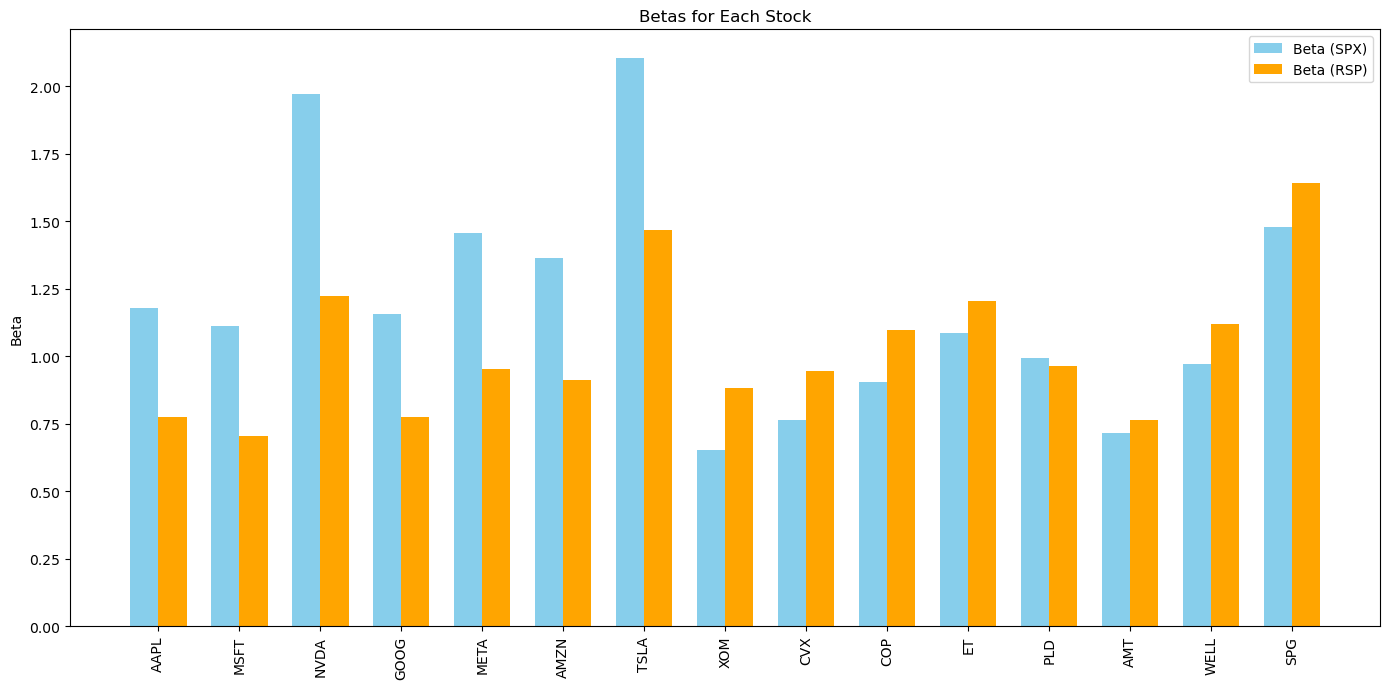

In [24]:
tickers = betas_df.index.tolist()
N = len(tickers)
ind = np.arange(N)  
width = 0.35        

fig, ax = plt.subplots(figsize=(14, 7))

bar_spx = ax.bar(ind - width/2, betas_df['beta_spx'], width, label='Beta (SPX)', color='skyblue')
bar_rsp = ax.bar(ind + width/2, betas_df['beta_rsp'], width, label='Beta (RSP)', color='orange')

ax.set_ylabel("Beta")
ax.set_title("Betas for Each Stock")
ax.set_xticks(ind)
ax.set_xticklabels(tickers, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

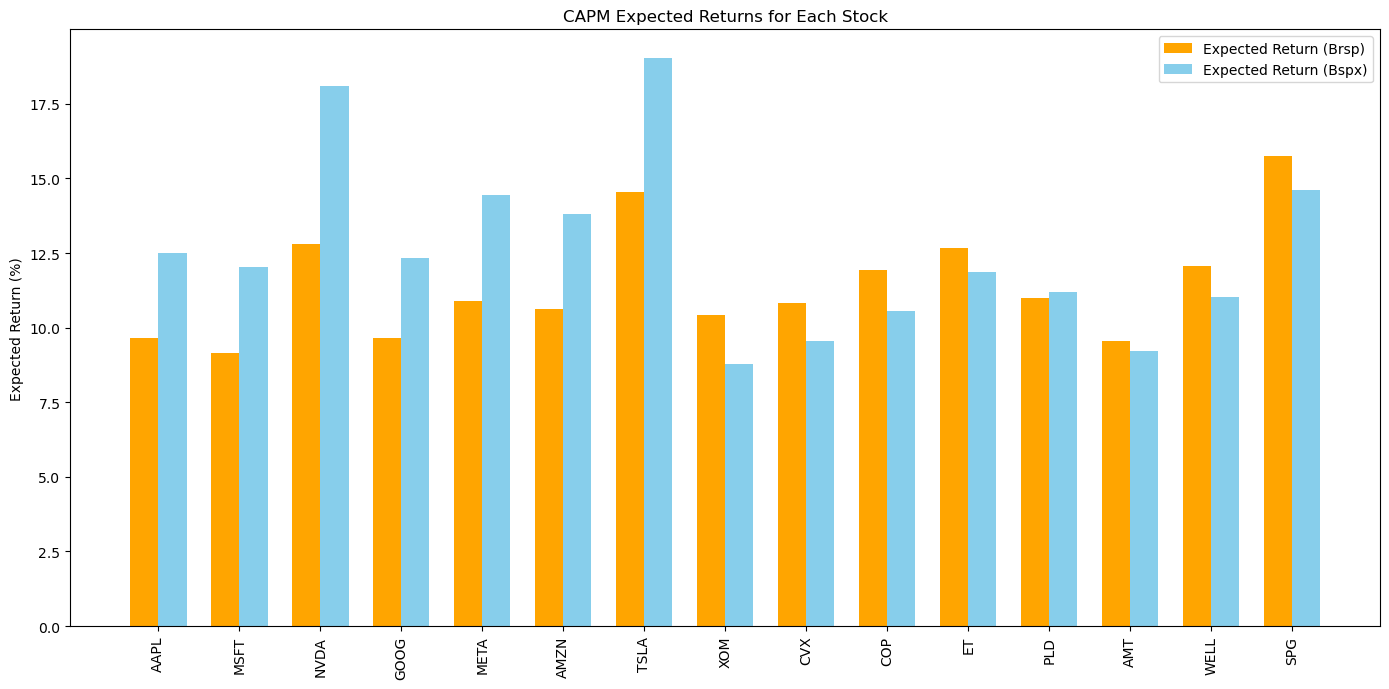

In [25]:
# grouped bar chart
tickers = betas_df.index.tolist()
N = len(tickers)
ind = np.arange(N)  
width = 0.35       

fig, ax = plt.subplots(figsize=(14, 7))

bar1 = ax.bar(ind - width/2, betas_df['Expected Return(Brsp)'], width, label='Expected Return (Brsp)', color='orange')
bar2 = ax.bar(ind + width/2, betas_df['Expected Return(Bspx)'], width, label='Expected Return (Bspx)', color='skyblue')


ax.set_ylabel("Expected Return (%)")
ax.set_title("CAPM Expected Returns for Each Stock")
ax.set_xticks(ind)
ax.set_xticklabels(tickers, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

- We can see that tech stocks get inflated results due to their correlation(or inclusion) in the tech industry as a whole.
- The Energy, and Real Estate sectors get higher expected returns when CAPM is calculated using the RSP, because of their higher representation in that index


## Simulating stock prices for 2025 using CAPM calculated expected return as mu term

##### Computing expected annual volatility for each stock: 

$$\hat{\sigma} = \frac{s}{\sqrt{\tau}}$$

Where: 

- ${s}$ is the daily standard deviation of stock returns
- ${\tau}$ is the intervals measured in years. Using weekly price data, dt is 1/52

In [16]:
logrets_std = log_returns.std()
stock_annualized_std = logrets_std / np.sqrt(1/52)
logrets_std, stock_annualized_std

(Ticker
 AAPL    0.040153
 AMT     0.041218
 AMZN    0.049038
 COP     0.057561
 CVX     0.041408
 ET      0.059485
 GOOG    0.041187
 META    0.062823
 MSFT    0.036079
 NVDA    0.071073
 PLD     0.038630
 SPG     0.064713
 TSLA    0.099226
 WELL    0.055419
 XOM     0.043220
 dtype: float64,
 Ticker
 AAPL    0.289544
 AMT     0.297230
 AMZN    0.353615
 COP     0.415075
 CVX     0.298596
 ET      0.428951
 GOOG    0.297002
 META    0.453020
 MSFT    0.260166
 NVDA    0.512516
 PLD     0.278567
 SPG     0.466650
 TSLA    0.715526
 WELL    0.399630
 XOM     0.311664
 dtype: float64)

In [17]:
params_df = pd.DataFrame({
    'Expected Return(Bspx)': betas_df['Expected Return(Bspx)'],
    'Expected Return(Brsp)': betas_df['Expected Return(Brsp)'],
    'Annualized Volatility': stock_annualized_std,
    'Sigma^2': stock_annualized_std**2
})

print(params_df)

        Expected Return(Bspx)  Expected Return(Brsp)  Annualized Volatility  \
Ticker                                                                        
AAPL                12.492900               9.656556               0.289544   
AMT                  9.217617               9.568272               0.297230   
AMZN                13.816496              10.617895               0.353615   
COP                 10.551318              11.937426               0.415075   
CVX                  9.564037              10.839715               0.298596   
ET                  11.854872              12.680657               0.428951   
GOOG                12.348519               9.648298               0.297002   
META                14.449518              10.898988               0.453020   
MSFT                12.023145               9.157310               0.260166   
NVDA                18.094558              12.808513               0.512516   
PLD                 11.202389              10.994880

### Ready to simulate

$$S_{t+\Delta t} = S_t \exp \left[ \left(\mu - \frac{\sigma^2}{2} \right) \Delta t + \sigma \varepsilon \sqrt{\Delta t} \right]$$

Where: 

- $S_t$ is the stock price at time t
- $\Delta t$ is the time interval for prediction (1 day?)
- $\mu$ is the expected annual rate of return **ANNUAL**
- $\sigma$ is the expected annual volatility
- $\epsilon$ is a randomly drawn number from a normal distribution with a mean of zero and standard deviation of one, representing random volatility

In [18]:
num_simulations = 5000
num_periods = 52

# initialize df
simulated_prices_spx = pd.DataFrame(index=range(num_periods), columns=params_df.index)

# fetching last price from price data df
last_price = prices.iloc[-1]

for ticker in params_df.index:
    S0 = last_price[ticker]
    mu = params_df.loc[ticker, 'Expected Return(Bspx)'] / 100
    sigma = params_df.loc[ticker, 'Annualized Volatility']

    # dt, epsilon
    dt = 1/52
    epsilon = np.random.normal(0, 1, (num_periods, num_simulations))

    # initialize array
    prices = np.zeros((num_periods, num_simulations))
    prices[0] = S0

    # simulate prices
    for t in range(1, num_periods):
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * epsilon[t])

    # fill initialized df
    simulated_prices_spx[ticker] = prices.mean(axis=1)

simulated_prices_spx

Ticker,AAPL,AMT,AMZN,COP,CVX,ET,GOOG,META,MSFT,NVDA,PLD,SPG,TSLA,WELL,XOM
0,250.144974,181.795029,219.389999,98.371727,143.251099,19.277445,190.440002,585.510010,420.656525,134.289993,105.699997,172.210007,403.839996,126.029999,106.616348
1,250.867967,182.096845,219.762160,98.601914,143.532194,19.308287,191.069751,587.943875,421.519408,134.751305,105.957562,172.973327,405.745640,126.145591,106.774289
2,251.149217,182.541890,220.427502,98.755249,143.737905,19.363334,191.469788,589.872597,422.406636,135.285770,106.158561,173.565466,406.615983,126.511490,106.958462
3,251.870722,182.799120,220.942473,98.804538,144.079615,19.387067,192.088228,592.303107,422.855066,135.802319,106.274161,174.079441,408.425564,126.961095,107.064643
4,252.413919,183.230299,221.414630,99.008147,144.291949,19.449234,192.485128,593.540573,423.819814,136.301850,106.455888,174.381332,408.766582,127.404628,107.364285
5,253.123048,183.850125,221.991419,99.105889,144.527017,19.494714,192.784664,594.458081,424.635297,136.846249,106.773299,174.680679,410.754082,127.694749,107.561680
6,253.832863,183.988592,222.579005,99.465518,144.668218,19.559946,193.151272,595.434218,425.463199,137.598594,106.949812,175.228791,412.753162,127.859060,107.824536
7,254.395303,184.233162,223.279429,99.671549,144.842160,19.604788,193.764351,597.024920,426.621630,137.878225,107.169724,175.981358,414.657804,128.290925,108.098541
8,254.995120,184.570824,223.815471,99.951934,144.964310,19.666269,194.116284,598.777995,427.100710,138.444732,107.221049,176.534168,416.262253,128.732416,108.265236
9,255.346672,185.003895,224.335765,100.116558,145.214047,19.705711,194.636321,600.486808,427.714357,138.859508,107.399511,176.746644,417.588266,129.004753,108.460779


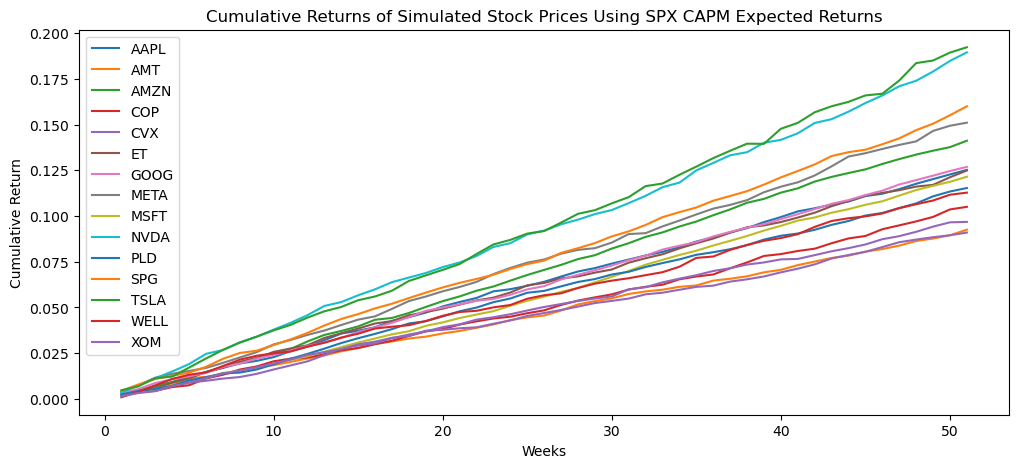

In [19]:
# compute daily rets
sim_cumrets_spx = simulated_prices_spx.pct_change().dropna()

# cumprod
cumulative_returns_spx = (1 + sim_cumrets_spx).cumprod() - 1

plt.figure(figsize=(12, 5))

for ticker in cumulative_returns_spx.columns:
    plt.plot(cumulative_returns_spx[ticker], label=ticker)

plt.title('Cumulative Returns of Simulated Stock Prices Using SPX CAPM Expected Returns')
plt.xlabel('Weeks')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [20]:
num_simulations = 5000
num_periods = 52

# initialize df
simulated_prices_rsp = pd.DataFrame(index=range(num_periods), columns=params_df.index)

# last price series already created

for ticker in params_df.index:
    S0 = last_price[ticker]
    mu = params_df.loc[ticker, 'Expected Return(Brsp)'] / 100
    sigma = params_df.loc[ticker, 'Annualized Volatility']

    # dt, epsilon
    dt = 1/52
    epsilon = np.random.normal(0, 1, (num_periods, num_simulations))

    # initialize array
    prices = np.zeros((num_periods, num_simulations))
    prices[0] = S0

    # simulate prices
    for t in range(1, num_periods):
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * epsilon[t])

    # fill initialized df
    simulated_prices_rsp[ticker] = prices.mean(axis=1)

simulated_prices_rsp

Ticker,AAPL,AMT,AMZN,COP,CVX,ET,GOOG,META,MSFT,NVDA,PLD,SPG,TSLA,WELL,XOM
0,250.144974,181.795029,219.389999,98.371727,143.251099,19.277445,190.440002,585.510010,420.656525,134.289993,105.699997,172.210007,403.839996,126.029999,106.616348
1,250.738676,181.937749,219.684979,98.672546,143.576100,19.327593,190.534281,586.791218,421.285793,134.468762,105.999325,172.400498,404.553641,126.378950,106.953334
2,251.112967,182.337819,219.940944,98.782847,144.024368,19.393086,190.843101,588.449621,422.055300,134.577675,106.298832,172.843858,405.040963,126.693500,107.099629
3,251.914532,182.676880,220.054258,99.052176,144.191037,19.441746,191.263568,589.619237,422.928431,134.944522,106.606648,173.246734,406.369644,126.893991,107.307834
4,252.623920,183.060737,220.637434,99.264358,144.418419,19.489227,191.388982,591.525836,424.166750,135.477450,106.814084,173.577411,407.594636,127.241889,107.532723
5,253.046978,183.587382,221.040194,99.476597,144.767040,19.517755,191.721920,593.619428,424.834203,135.845170,107.005236,174.048652,408.256345,127.459342,107.687564
6,253.494849,184.024195,221.514289,99.841714,144.964469,19.558430,192.190734,594.397433,425.284729,136.003132,107.169508,174.556155,408.755086,127.644582,107.967707
7,253.872040,184.497446,221.964240,100.119458,145.351283,19.630514,192.673404,595.421439,426.183235,136.247766,107.351816,175.155707,410.002228,127.954876,108.273321
8,254.164351,184.807602,222.541953,100.314407,145.613630,19.648147,193.050853,597.700620,426.676782,136.714546,107.569913,175.634662,411.668421,128.164517,108.552980
9,254.753350,185.185053,222.999057,100.475617,145.880526,19.714263,193.466861,599.082438,427.653247,136.947532,107.774610,176.422999,413.578875,128.574081,108.734649


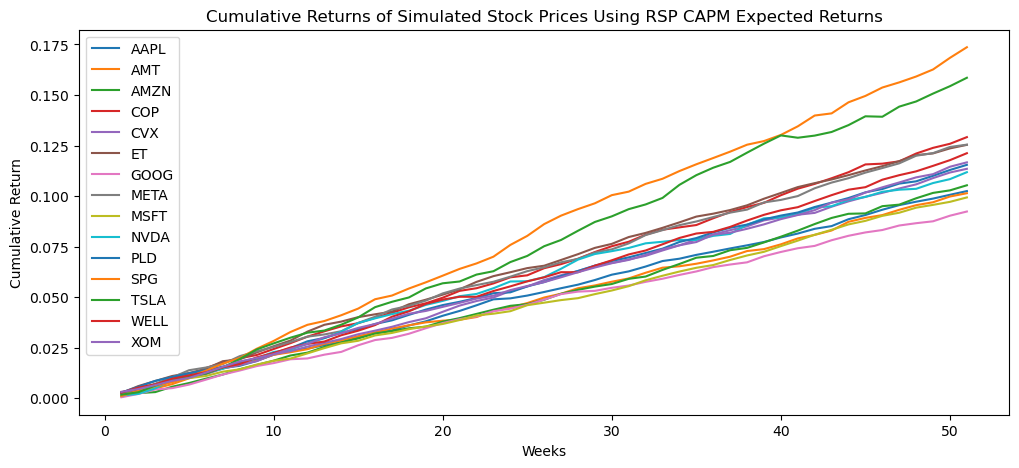

In [21]:
# compute daily rets
sim_cumrets_rsp = simulated_prices_rsp.pct_change().dropna()

# cumprod
cumulative_returns_rsp = (1 + sim_cumrets_rsp).cumprod() - 1

plt.figure(figsize=(12, 5))

for ticker in cumulative_returns_rsp.columns:
    plt.plot(cumulative_returns_rsp[ticker], label=ticker)

plt.title('Cumulative Returns of Simulated Stock Prices Using RSP CAPM Expected Returns')
plt.xlabel('Weeks')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [22]:
daily_simrets_spx = simulated_prices_spx.pct_change().dropna()
daily_simrets_rsp = simulated_prices_rsp.pct_change().dropna()

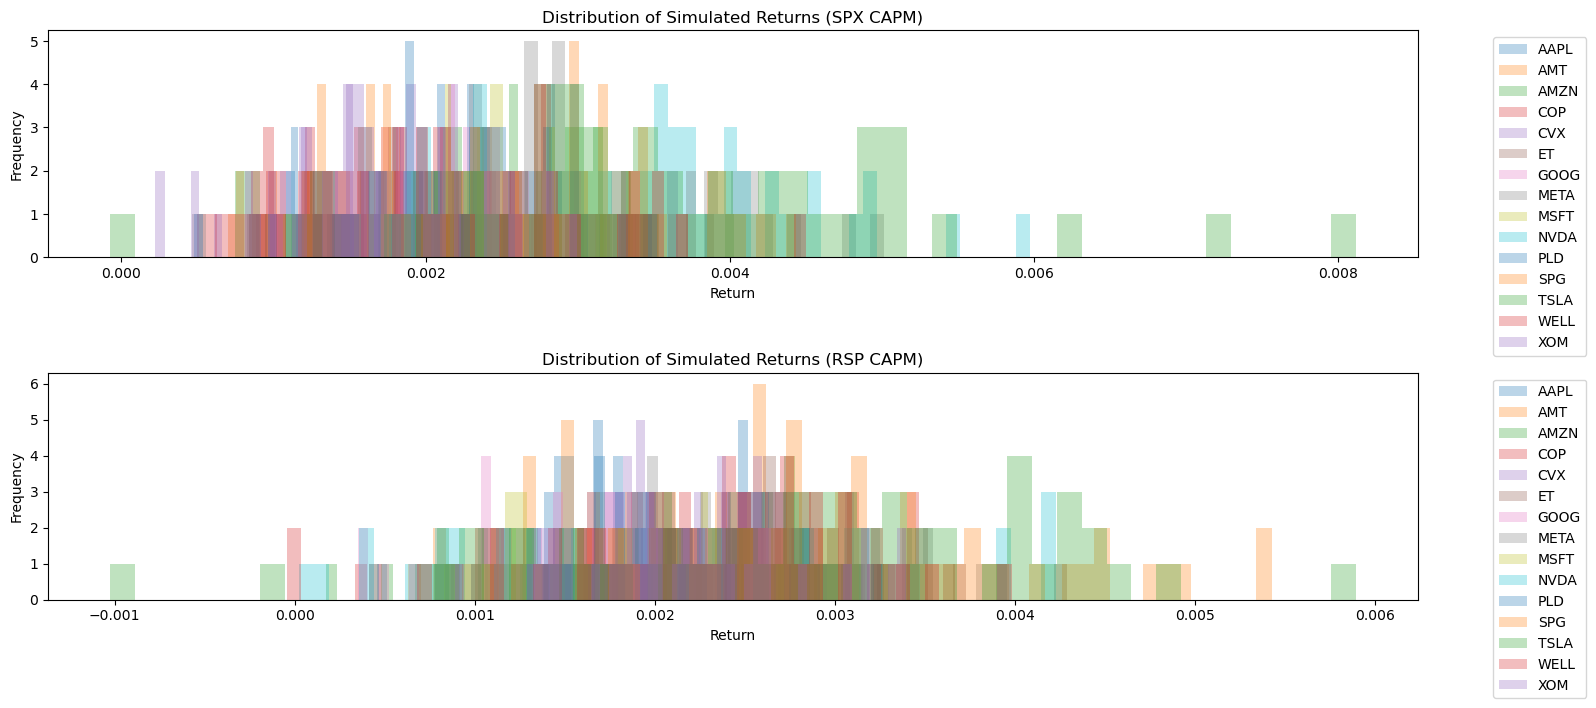

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 7))

# plot histogram for SPX-based returns
for column in daily_simrets_spx.columns:
    ax1.hist(daily_simrets_spx[column], bins=50, alpha=0.3, label=column)
ax1.set_title('Distribution of Simulated Returns (SPX CAPM)')
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plot histogram for RSP-based returns
for column in daily_simrets_rsp.columns:
    ax2.hist(daily_simrets_rsp[column], bins=50, alpha=0.3, label=column)
ax2.set_title('Distribution of Simulated Returns (RSP CAPM)')
ax2.set_xlabel('Return')
ax2.set_ylabel('Frequency')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

- Slightly fatter tails in the SPX CAPM simulated returns

- What does this tell us about risk assesment?

In [ ]:

def compare_tail_metrics(sim_returns_1, sim_returns_2):
    """
    Compare the tail behavior of two simulated return distributions.
    
    Args:
        sim_returns_1 (np.array): Simulated returns from experiment 1.(SPX)
        sim_returns_2 (np.array): Simulated returns from experiment 2.(RSP)
        
    Returns:
        A dictionary with kurtosis and extreme quantile values.
    """
    # calculate excess kurtosis
    excess_kurtosis_1 = stats.kurtosis(sim_returns_1, fisher=True)
    excess_kurtosis_2 = stats.kurtosis(sim_returns_2, fisher=True)
    
    # calculate 1st and 99th quantiles
    q1_1, q99_1 = np.percentile(sim_returns_1, [1, 99])
    q1_2, q99_2 = np.percentile(sim_returns_2, [1, 99])
    
    return {
        "excess_kurtosis": { "SPX based simulations": excess_kurtosis_1, "RSP based simulations": excess_kurtosis_2 },
        "extreme_quantiles": {
            "SPX based simulations": {"1st": q1_1, "99th": q99_1},
            "RSP based simulations": {"1st": q1_2, "99th": q99_2},
        }
    }


In [36]:
np.random.seed(0)

tail_metrics = compare_tail_metrics(daily_simrets_spx, daily_simrets_rsp)
print("Excess Kurtosis:")
print(pd.DataFrame(tail_metrics["excess_kurtosis"]))
print("\nExtreme Quantiles (1st and 99th):")
print(pd.DataFrame(tail_metrics["extreme_quantiles"]))

Excess Kurtosis:
    SPX based simulations  RSP based simulations
0               -0.446153              -0.166558
1                0.082244               0.452576
2                0.168423              -0.781301
3               -0.568478              -0.141588
4                0.917638              -0.586198
5               -0.839372              -0.170786
6               -0.253513              -0.580050
7               -0.331160              -0.696408
8                0.012176              -1.111262
9               -0.450470              -0.720820
10              -0.330952               0.657310
11              -0.372003              -0.156893
12               0.742224               0.557472
13              -0.610939               1.073016
14              -0.561626              -0.186042

Extreme Quantiles (1st and 99th):
      SPX based simulations  RSP based simulations
1st                0.000575               0.000345
99th               0.005030               0.004547


### Overall, the SPX based simulation produces a fatter-tailed distribution vs the RSP based simulation

- Extreme Quantiles:
    - The SPX‐based simulations have a 99th quantile of 0.00503 compared to 0.00455 for the RSP‐based simulations. Even though the 1st quantile is a bit higher for SPX (0.000575 vs. 0.000345), the overall spread (upper minus lower) is wider for SPX (about 0.00446 vs. 0.00420). This wider range implies that the SPX‐based return distributions allow for more extreme (particularly high) outcomes

- Excess Kurtosis:
    - While individual simulation runs show variability—with both benchmarks occasionally yielding positive or negative excess kurtosis—the pattern of the extreme quantiles reinforces that the SPX‐based simulations generally exhibit fatter tails. Fatter tails mean a higher likelihood of extreme deviations, and the SPX figures support that in the upper tail.



In [ ]:
s